# Proyecto: Generación de paleta de colores a partir de imágenes con técnicas de machine learning no supervisado

Se requiere realizar un modelo de Machine Learning no Supervisado, a través de las técnicas de agrupación, para generar una paleta de colores que permita describir los principales tonos de una obra de arte y su distribución. Las pinturas se obtendran a traves de imagenes descargadas de la página https://www.kaggle.com/datasets/steubk/wikiart.

Para lograr este modelo, se realizaran los siguientes pasos:

1. Importar las librerías necesarias.
2. Construir las principales funciones que se van a usar en el análisis y construcción del modelo.
3. Cargar, transformar y preparar los datos para el modelado.
4. Entrenar un modelo de K-means.
5. Entrenar un modelo de MeanShift.
6. Comparar los modelos.
7. Automatización de la paleta de colores.
8. Análisis de resultados.

## Objetivos

* Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de una imagen y generar un muestrario de los colores presentes en esta.

## 1. Importación de librerías requeridas

Importaremos las librerías pandas y scikit-learn. En particular, usaremos las siguientes clases y funciones:

* Kmeans: usado para agrupar píxeles en función de la cercanía que tienen en distancia.
* MeanSchift: usado para agrupar píxeles en función de la densidad que los acerca.
* cv2: se usa para cargar imágenes, mantener su estructura RGB y disminuir los pixeles para hacer la imágen más pequeña.
* TSNE: se usa para mapear el espacio 3D de la imagen a uno 2D y poder visualizar la distribución de los colores.

In [263]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.pipeline import Pipeline

from sklearn.manifold import TSNE

from collections import Counter


## 2. Construir las principales funciones que se van a usar en el análisis y construcción del modelo.

Se contruyen las siguientes funciones que se van a usar a lo largo del proyecto.

### 2.1. Clases LoadImages, ResizeImages y ReshapeScaledImages

* La clase LoadImages se usa para cargar imagenes y mantener la estructura RGB.
* La clase ResizeImages se usa para cambiar el tamaño de la imágen y se usa para disminuit en 50% la escala de las imágenes cargadas.
* La clase ReshapeScaledImages se usa para cambiar la forma original de la imagen a un array de 3 columnas y n filas y aparte reescalar los datos a valores entre 0 y 1.

Estás clases se usaran en Pipelines.

In [264]:
class LoadImages:
    
    def __init__(self, root_path, file_name):
        self.root_path = root_path
        self.file = file_name
        
    def transform(self, X = None):
        
        img = cv2.imread(os.path.join(self.root_path, self.file)) #Carga la imagen Y DEVUELVE UN ARRAY
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # mantiene el sistema de colores RGC
        
        return img
    
    
class ResizeImages:
    
    def __init__(self, scale = 0.5):
        self.scale = scale # Escala que se usa para disminuir el tamaño de la imágen
        
    def transform(self, img):
        
        img = cv2.resize(img, (0, 0), fx = self.scale, fy = self.scale) # Disminución del tamaño de la imágen
        
        return img

class ReshapeScaledImages:
        
    def transform(self, img):
        
        img = img.reshape((-1, 3)) # convertir una imagen en un array de n filas y 3 columns que representan el sistema RGB
        img = img / 255.0 # reescalar el tamaño de la imagen de [0,255] a [0,1]
        
        return img


### 2.2. Función elbow_prot
Se usa la función elbow_plot para determinar el número adecuado de clusters (k) en un conjunto de datos mediante el algoritmo K-Means. Para ello, se evalúa la inercia (SSE - Suma de los Errores Cuadráticos) para distintos valores de k, desde k_min hasta k_max, y genera una gráfica que muestra la relación entre el número de clusters y la inercia. El punto donde la curva comienza a disminuir más lentamente representa el valor adecuado de k, conocido como el "codo" de la gráfica. Esta técnica es ampliamente utilizada en aprendizaje no supervisado para seleccionar un número adecuado de clusters en problemas de clasificación

In [ ]:
def elbow_plot(X, k_min=2, k_max=10):
    """
    Genera la gráfica para el método del codo usando KMeans sobre un conjunto X de pixeles.
    """
    inertias = []
    ks = range(k_min, k_max+1)
    for k in ks:
        kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('Inercia (SSE)')
    plt.title('Método del codo (KMeans)')
    plt.grid()
    plt.show()

### 2.3. Función plot_kMeans_RGB
La función plot_kMeans_RGB se usa para mostrar una imagen en 3D de la distribución de colores y también los puntos centroides que se encuentran el proceso de KMeans. Debido a la densidad de la imágen, solo se grafica un 10% aleatorio de los píxeles para una visualización más clara.

In [265]:
def plot_kMeans_RGB(X, centroids):
    # Plot the colors and centroids in a 3D space
    
    sample_size = int(0.01 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], sample_size, replace = False)
    X_sample = X[sample_indices]
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(221, projection='3d')
    ax.scatter(*X_sample.T*255, zdir='z', depthshade=False, s=.3, c=X_sample)
    ax.scatter(*centroids.T*255, zdir='z', depthshade=False, s=500, c='red', marker='x', lw=3)
    ax.set_xlabel('R value - Redness')
    ax.set_ylabel('G value - Greenness')
    ax.set_zlabel('B value - Blueness')
    ax.w_yaxis.set_pane_color((0., 0., 0., .2))
    ax.set_title("Original colors and their color clusters' centroids")
    plt.show()


### 2.4. Función plt_images_original_versus_segmentada

La función plt_images_original_versus_segmentada se usa para mostrar la imágen original versus la imagen segmentada por el proceso de clusterización.

In [ ]:
def plt_images_original_versus_segmentada(img_ori, img_seg):
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(img_ori)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Imagen Segmentada')
    plt.imshow(img_seg.astype(np.uint8))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### 2.5. Función tsne_distribution
La función tsne_distribution se usa para aplicar la transformación TSNE que mapea el espacio 3D de la imagen procesada a un espacio 2D para graficar en el plano la distribución de los colores. Debido a la densidad de la imagen solo se mapea el 10% alatorio de los píxeles.


In [298]:
def tsne_distribution(X):
    
    tsne = TSNE(n_components = 2, perplexity=30, random_state=42)

    sample_size = int(0.01 * X.shape[0])
    sample_indices = np.random.choice(X.shape[0], sample_size, replace = False)
    X_sample = X[sample_indices]

    pixels_tsne = tsne.fit_transform(X_sample)

    plt.figure(figsize=(8, 6))
    plt.scatter(pixels_tsne[:, 0], pixels_tsne[:, 1], s=1, c=X_sample, marker="o")
    plt.axis("off")
    plt.title("t-SNE aplicado a la imagen")
    plt.show()


### 2.6. Función generate_color_palette

La función generate_color_palette se usa para mostrar una paleta de los principales colores obtenidos en el proceso de clusterización y de manera ordenada de izquierda a derecha, en función de la importancia según la frecuencia obtenida.

In [227]:
def generate_color_palette(centroids, labels, title="Paleta de Colores"):
    """
    Genera una representación visual de la paleta de colores resultante tras la segmentación.
    Ordena los colores de mayor a menor frecuencia y agrega etiquetas con los valores RGB.

    Parámetros:
    -----------
    model : objeto de clustering (ej. KMeans, MeanShift)
        Debe tener un atributo 'cluster_centers_' con los centroides.
    labels : array-like
        Etiquetas de clúster asignadas a cada píxel.
    """

    # Se cuenta la frecuencia de cada etiqueta
    label_counts = Counter(labels)
    total_pixels = sum(label_counts.values())

    # Se ordenan los colores por frecuencia
    freq_sorted = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_centroids = [centroids[idx] for idx, _ in freq_sorted]
    sorted_freqs = [label_counts[idx] for idx, _ in freq_sorted]

    # Crear figura más delgada y ancha
    fig, ax = plt.subplots(figsize=(8, 1))  
    plt.title(title, fontsize=10)

    left_position = 0
    for i, freq in enumerate(sorted_freqs):
        ratio = freq / total_pixels
        color_rgb = sorted_centroids[i]  # [R, G, B] en [0,1]
        
        # Dibujar barra de color
        ax.barh([0], ratio, left=left_position, color=color_rgb)

        # Calcular posición de la etiqueta (centrado en la barra)
        text_x = left_position + (ratio / 2)  # Centrar el texto dentro del color
        text_y = 0  # Centrado en la barra
        
        # Convertir valores a formato RGB [0,255]
        rgb_values = tuple(int(c * 255) for c in color_rgb)

        # Definir tamaño y ángulo de la fuente para evitar superposiciones
        font_size = max(6, 12 * ratio)  # Reducir fuente si el espacio es pequeño
        rotation_angle = 0  # Mantener horizontal
        
        # Agregar etiqueta con el color, verificando si hay suficiente espacio
        if ratio > 0.12:  # Solo poner texto si el espacio es suficiente
            ax.text(text_x, text_y, f"{rgb_values}", ha='center', va='center', 
                    fontsize=font_size, color='white' if sum(rgb_values) < 300 else 'black', 
                    rotation=rotation_angle, fontweight='bold')

        left_position += ratio

    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.show()


### 3. Cargar, transformar y preparar los datos para el modelado.

Se cargan los datos de las imágenes que se encuentran en la ruta "imagenes" y se automatiza en un Pipeline carga de la imagén original y en otro Pipeline la imagen procesada y convertidad en un array de n filas y 3 columnas y reescaladas a [0,1].

### 3.1. Imágenes en la ruta "imagenes"

In [231]:
root_path = 'imagenes'
files_names = os.listdir(root_path)
files_names

['NAIVE_ART_PRIMITIVISM-aldemir-martins_macuna-ma-1982.jpg',
 'NAIVE_ART_PRIMITIVISM-andre-bauchant_personnages-et-fleurs-1947.jpg',
 'NEW_Realism-edward-hopper_adam-s-house.jpg',
 'NEW_Realism-edward-hopper_d-r-g-locomotive.jpg']

### 3.2. Pipeline images

El Pipeline images se usa para cargar una imágen específica y disminuir su tamaño al 50% usando las clases LoadImages y ResizeImages. Con esto se guarda la imágen original.

In [234]:
file_name = 'NAIVE_ART_PRIMITIVISM-aldemir-martins_macuna-ma-1982.jpg'

images = Pipeline(
    [
        ('load_images', LoadImages(root_path, file_name)),
        ('resize_images', ResizeImages(0.5))
    ]
)

processed_image = images.transform([])


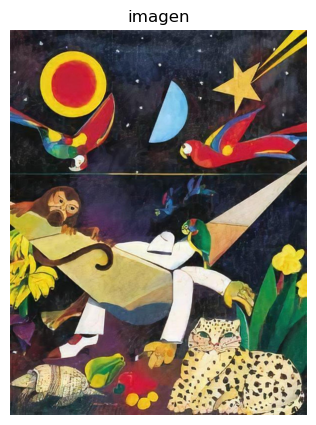

In [235]:
plt.figure(figsize=(10, 5))
plt.plot(1, 2, 1)
plt.title('imagen')
plt.imshow(processed_image[0])
plt.axis('off')
plt.show()

### 3.3. Pipeline images_transform

El Pipeline images_transform se usa junto con el Pipeline images para no solo cargar la imagen sino transformarla en un array de n filas y 3 columnas de escala [0,1].

In [239]:
images_transform = Pipeline(
    [
        ('image_preprocessing', images),
        ('image_reshape', ReshapeScaledImages())
    ]
)

processed_images_transform = images_transform.transform([])

In [240]:
processed_images_transform

array([[0.35686275, 0.28235294, 0.30588235],
       [0.35686275, 0.28235294, 0.30588235],
       [0.34509804, 0.27058824, 0.29411765],
       ...,
       [0.14901961, 0.18039216, 0.19215686],
       [0.18039216, 0.21176471, 0.22352941],
       [0.16862745, 0.2       , 0.21176471]])

In [241]:
processed_images_transform.shape

(620518, 3)

 Las dimensiones del conjunto de entrenamiento son correctas (alto*ancho, canales)

In [267]:
X = processed_images_transform          # Datos (pixeles normalizados)
original_shape = processed_images.shape


In [268]:
print("Dimensiones de X:", X.shape)  # (num_muestras, num_características)


Dimensiones de X: (620518, 3)


## 4. Entrenar un modelo de K-means.

Se utilizan los datos procesados para aplicar la clusterización de KMeans pero primero se aplica el método del codo para encontrar el número adecuado de clusters.

### 4.1. Aplicación del método del codo

Se aplica la función del método del codo para encontrar un número adecuado de clusters.

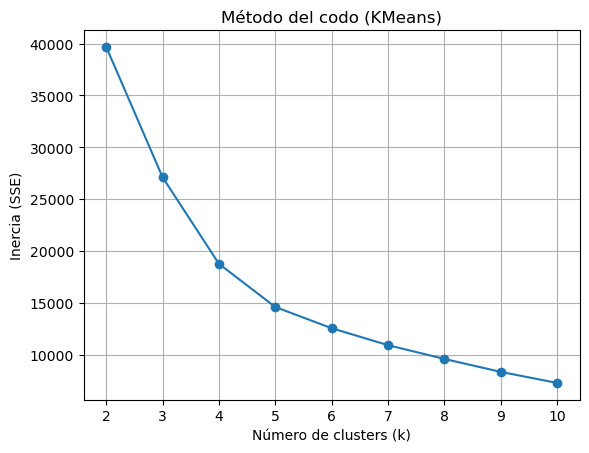

In [269]:
elbow_plot(X, 2, 10)


Como se evidencia en la gráfica del codo. Un número adecuado de clusters para la imagen podría ser 5, aunque no están claro y para otras imágenes este número podría variar. 

### 4.2. Entremiento del modelo KMeans

Se entrena el modelo Kmeans para la imágen con el número de clusters que se escogió.

In [270]:
num_clusters = 5

In [271]:
kmeans = KMeans(n_clusters=num_clusters, n_init=100, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, n_init=100, random_state=0)

In [272]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_  # Estos son los colores en [0,1]
centroids

array([[0.14233891, 0.14844642, 0.16524909],
       [0.81857849, 0.71900602, 0.33905419],
       [0.29221406, 0.29909174, 0.28906864],
       [0.71345248, 0.21165091, 0.21141368],
       [0.88251431, 0.86723391, 0.77979712]])

### 4.3. Segmentación de la imágen

Se usan los centroides hallados por el módelo para segmentar la imágen y comparla con la original

In [274]:
# Reemplazamos cada píxel por el centroide que le corresponde
img_segmented_kmeans = centroids[labels]

# Volvemos a [0,255]
img_segmented_kmeans = img_segmented_kmeans * 255

# Damos la forma original para poder visualizar
img_segmented_kmeans = img_segmented_kmeans.reshape(original_shape)


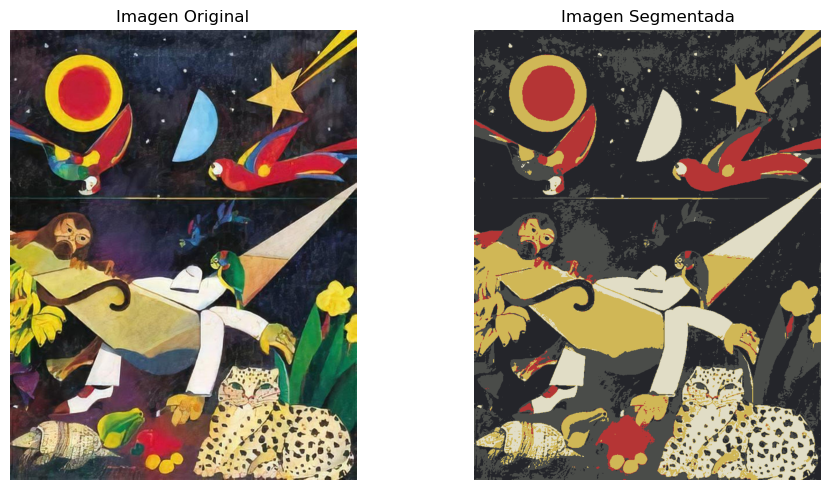

In [276]:
plt_images_original_versus_segmentada(processed_image[0], img_segmented_kmeans)

### 4.4. Paleta de colores y distibución de colores

Se grafica la paleta de los principales colores. 



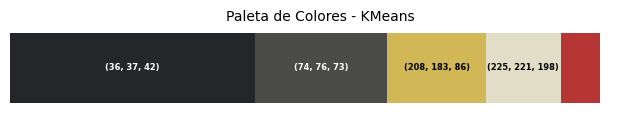

In [279]:
generate_color_palette(centroids, labels, title="Paleta de Colores - KMeans")


### 4.5. Grafica de la distribución de colores en 3D
Se grafican la distribución de un 10% aleatorio de los píxeles junto con los centroides que quedaron

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6948\532635478.py:15: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((0., 0., 0., .2))


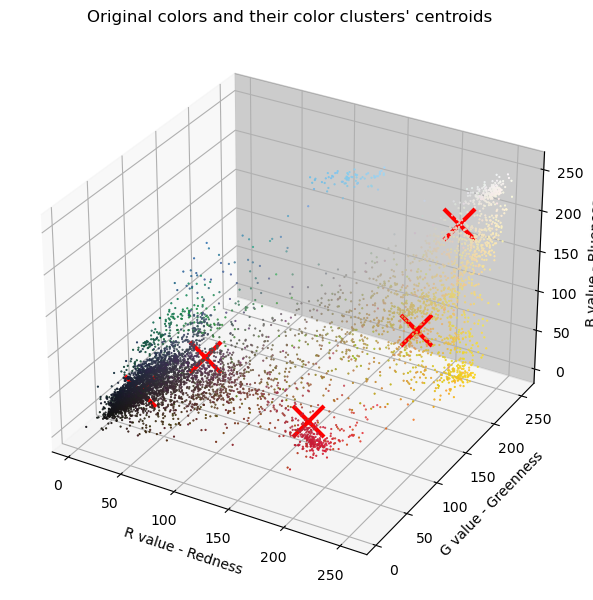

In [280]:
plot_kMeans_RGB(X, centroids)

### 4.6. Aplicación T-SNE

Otra manera de conocer la distribución de los colores de una manera más sencilla, graficando los píxeles en un plano 2D, es haciendo uso de T-SNE. Eso es muy útil para ver grupos o regiones de alta densidad.

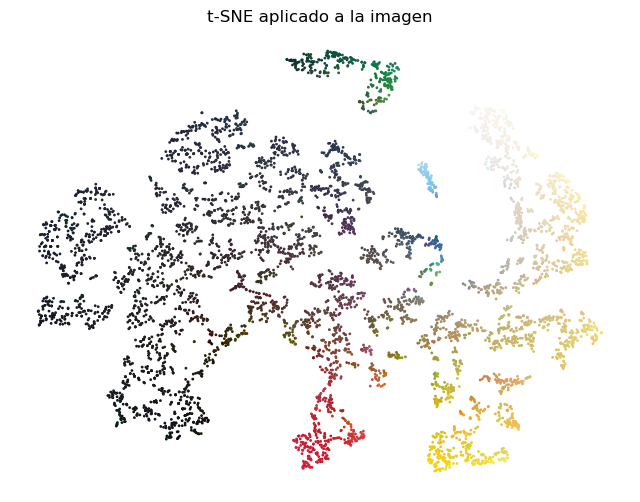

In [281]:
tsne_distribution(X)

Como se puede ver en ambas distribuciones, en la 3D y la 2D. Hay grandes grupos que la clusterización KMeans identifica bien pero hay otros pequeños que desaparecen como lo son los colores azulosos. Esto se debe a la manera en que agrupa y; que además, con el método del codo, no es tan claro si el grupo debería ser 5 o 6. Es por esto que se pueden aplicar otros métodos para ver cómo identifica los grupos de colores más importantes

## 5. Entrenar un modelo de MeanShift.

Se aplica el modelo de MeanShift a la imagen, la cual automaticamente genera el número de grupos más importantes.

### 5.1. Entrenamiento del modelo MeanShift

Se entrena el modelo con una densidad de 0.2 que significa que el radio de la ventana incluirá el 20% de los puntos más cercanos a cada muestra. Usa 5000 muestras (si hay más datos, toma una submuestra para estimar bandwidth y acelerar el cálculo

In [282]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=5000)  # samplea pixeles

In [283]:
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(X)

MeanShift(bandwidth=0.2554960371010193, bin_seeding=True)

In [284]:
labels_ms = meanshift.labels_
centroids_ms = meanshift.cluster_centers_
centroids_ms

print('Segeneraron:',len(centroids_ms), 'grupos')

Segeneraron: 5 grupos


### 5.2. Segmentación de la imágen.


In [286]:
img_segmented_ms = centroids_ms[labels_ms] * 255
img_segmented_ms = img_segmented_ms.reshape(original_shape)

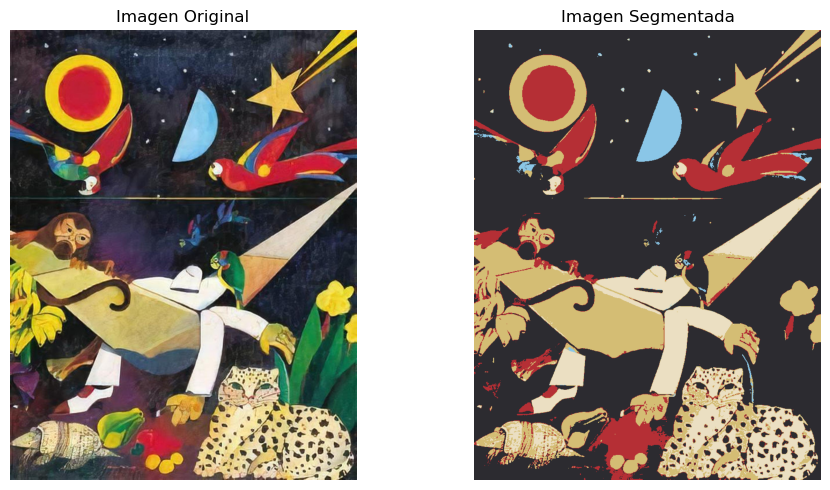

In [287]:
plt_images_original_versus_segmentada(img_original[0], img_segmented_ms)

### 5.3. Grafica de la distribución de colores en 3D

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6948\532635478.py:15: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((0., 0., 0., .2))


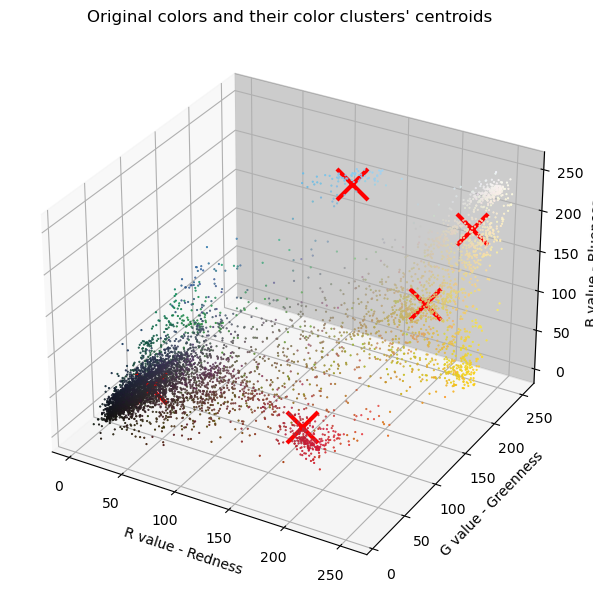

In [288]:
plot_kMeans_RGB(X, centroids_ms)

Como se evidencia con el nuevo modelo, aparecen 5 grupos también, pero aparece un nuevo color que antes no aparecía que es el azul.

## 6. Automatización de la paleta de colores.

Se contruye una función para que dada una imágen, se obtenga la imagen original versus la segmentada, se obtenga la paleta de colores y la distribución de los colores usando T-SNE. La función permite intoducir una variable que escoja el modelo entre KMeans o MeanShift.

In [252]:
def final_function(file_name, model):
    
    file_name = file_name

    images = Pipeline(
        [
            ('load_images', LoadImages(root_path, file_name)),
            ('resize_images', ResizeImages(0.5))
        ]
    )
    
    images_transform = Pipeline(
        [
            ('image_preprocessing', images),
            ('image_reshape', ReshapeScaledImages())
        ]
    )

    image = images.transform([])
    X = images_transform.transform([])
    original_shape = image.shape
    
    if model == 'kmeans':
        num_clusters = 6
        kmeans = KMeans(n_clusters=num_clusters, n_init=100, random_state=0)
        kmeans.fit(X)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        
    else:
        bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=5000)
        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        meanshift.fit(X)
        labels = meanshift.labels_
        centroids = meanshift.cluster_centers_
    
    img_segmented = centroids[labels]
    img_segmented = img_segmented * 255
    img_segmented = img_segmented.reshape(original_shape)
    
    plt_images_original_versus_segmentada(image, img_segmented)
    ima1 = generate_color_palette(centroids, labels, title=f"Paleta de Colores - {model}")
    itsne_distribution(X)

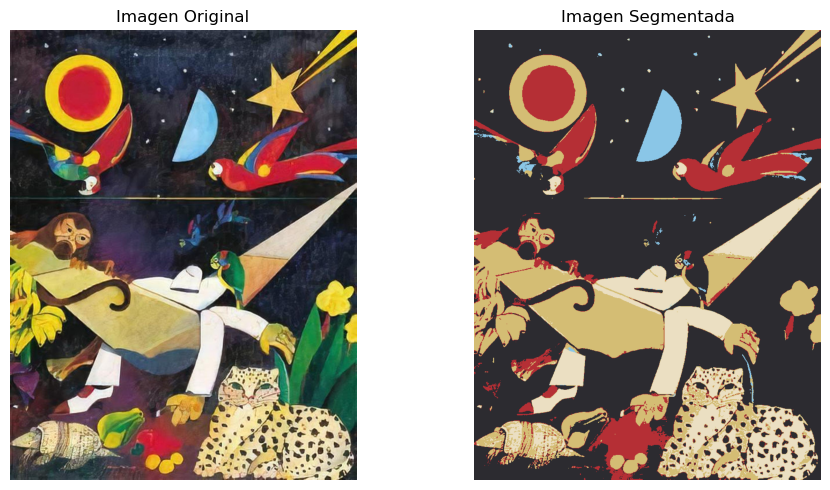

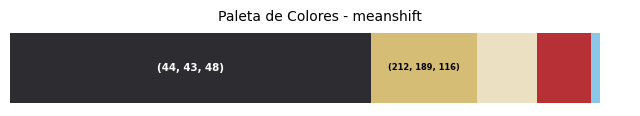

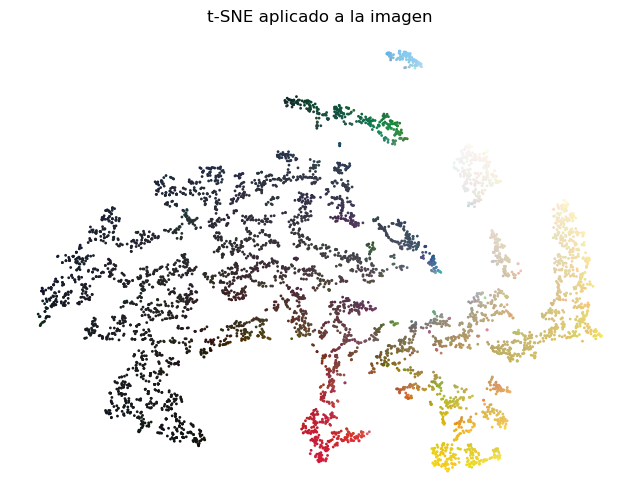

In [247]:
final_function(file_name = 'NAIVE_ART_PRIMITIVISM-aldemir-martins_macuna-ma-1982.jpg', model = 'meanshift')

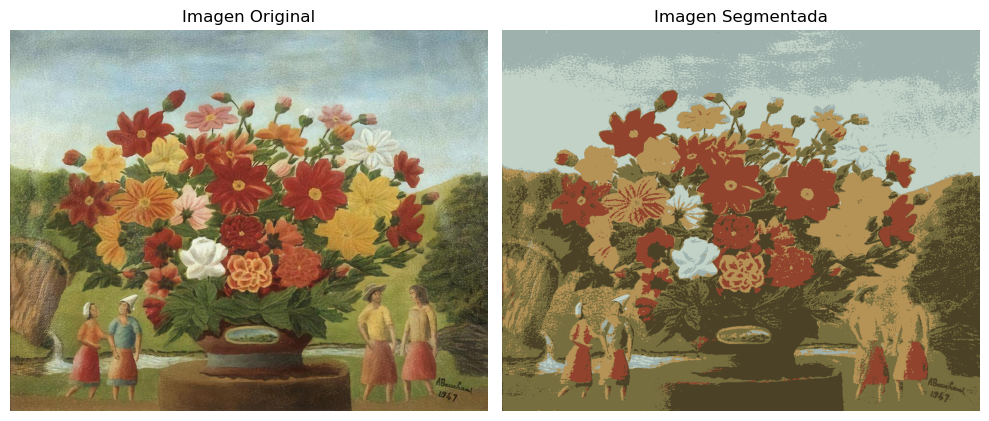

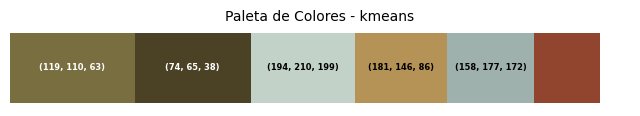

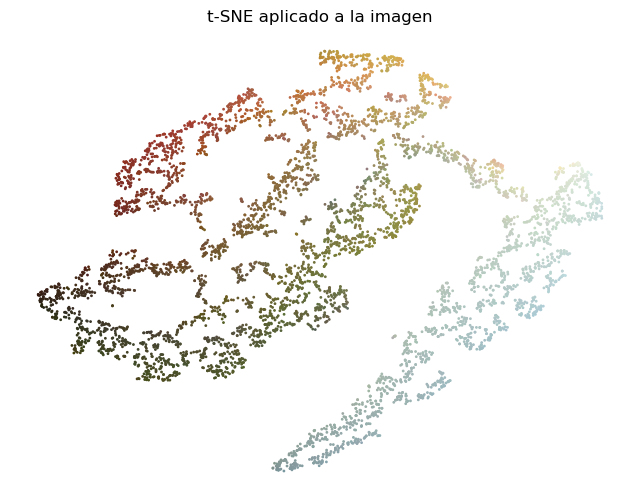

In [260]:
final_function(file_name = 'NAIVE_ART_PRIMITIVISM-andre-bauchant_personnages-et-fleurs-1947.jpg', model = 'kmeans')

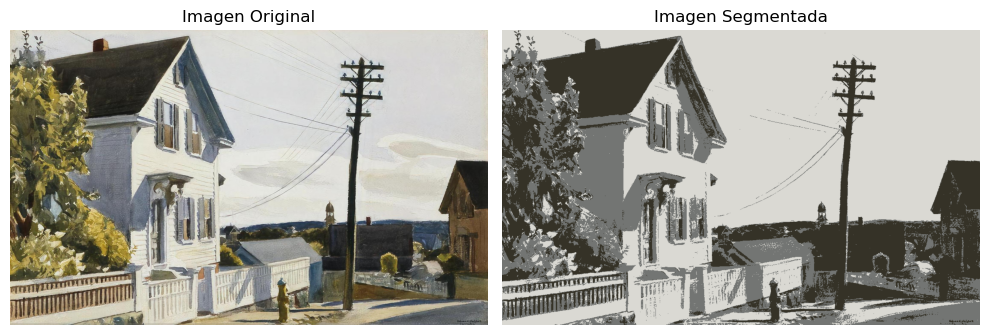

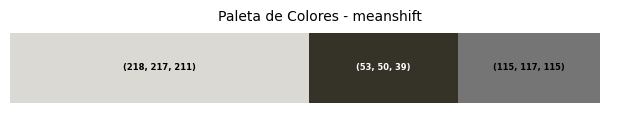

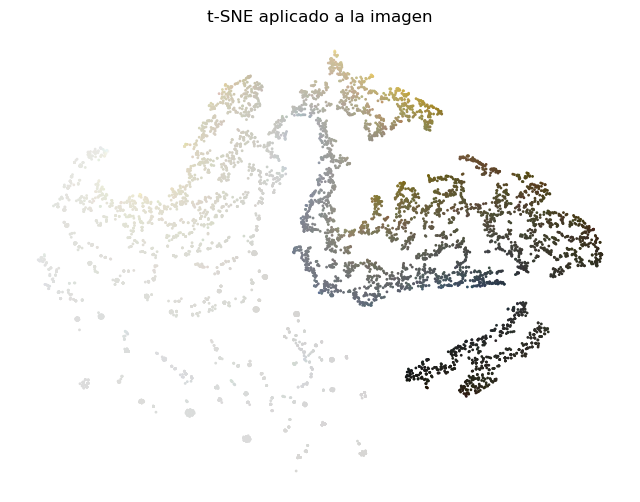

In [259]:
final_function(file_name = 'NEW_Realism-edward-hopper_adam-s-house.jpg', model = 'meanshift')

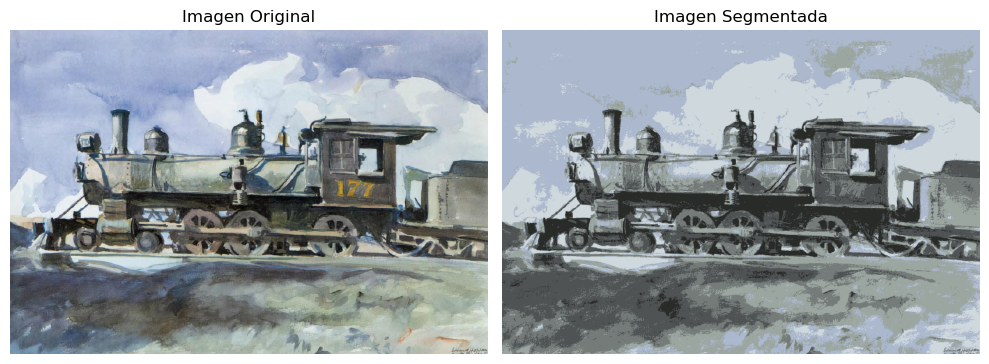

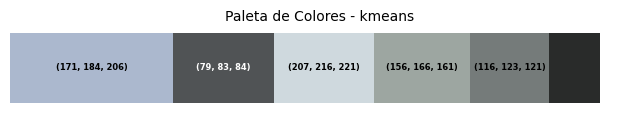

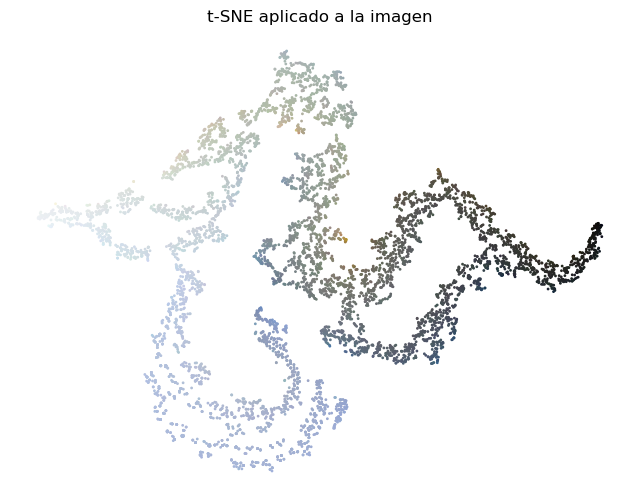

In [258]:
final_function(file_name = 'NEW_Realism-edward-hopper_d-r-g-locomotive.jpg', model = 'kmeans')